In [1]:
import math
import numpy as np

from skimage import io
from skimage.feature import canny
from skimage.filters import sobel, roberts
from skimage.transform import probabilistic_hough_line
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
#### Helpers for Pipeline
def normalize_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi


def get_dist(p0, p1):
    return np.linalg.norm([p1[0] - p0[0], p1[1] - p0[1]])


def get_dist_to_line(p, l):
    p0, p1 = l
    (px, py), (p0x, p0y), (p1x, p1y) = p, p0, p1 
    return np.abs((p1y - p0y) * px - (p1x - p0x) * py + p1x * p0y - p0x * p1y) / get_dist(p0, p1)


def get_side_of_line(p, l):
    p0, p1 = l
    return np.sign((p[0] - p0[0]) * (p1[1] - p0[1]) - (p[1] - p0[1]) * (p1[0] - p0[0]))


def get_angle(p0, p1):
    (p0x, p0y), (p1x, p1y) = p0, p1
    return np.arctan((p1y - p0y) / ((p1x - p0x) if (p1x - p0x) != 0 else 1e-9))


def get_angle_between_lines(l0, l1):
    v0x, v0y = l0[1][0] - l0[0][0], l0[1][1] - l0[0][1]
    v1x, v1y = l1[1][0] - l1[0][0], l1[1][1] - l1[0][1]
    return np.arccos((v0x * v1x + v0y * v1y) / (get_dist(l0[0], l0[1]) * get_dist(l1[0], l1[1])))


def get_intersection(l0, l1):
    (p00x, p00y), (p01x, p01y) = l0
    (p10x, p10y), (p11x, p11y) = l1
    denominator = (p00x - p01x) * (p10y - p11y) - (p00y - p01y) * (p10x - p11x)
    if denominator == 0:
        return None
    ix = ((p00x * p01y - p00y * p01x) * (p10x - p11x) - (p10x * p11y - p10y * p11x) * (p00x - p01x)) / denominator
    iy = ((p00x * p01y - p00y * p01x) * (p10y - p11y) - (p10x * p11y - p10y * p11x) * (p00y - p01y)) / denominator
    return ix, iy


def check_clockwise_order(points):
    p0, p1, p2, p3 = points
    direction = get_side_of_line(p2, (p0, p1))
    for pi, pj, pk in ((p1, p2, p3), (p2, p3, p0), (p3, p0, p1)):
        if get_side_of_line(pk, (pi, pj)) != direction:
            return False
    return True

In [3]:
## Helpers for rectangle extraction

def filter_edges(edges):
    h, w = edges.shape
    to_fill = np.zeros((h, w), dtype=bool)
    for i in range(3, h - 3):
        for j in range(3, w - 3):
            if edges[i, j] and (np.sum(edges[i - 3:i + 4, j - 3:j + 4]) > 10):
                to_fill[i, j] = 1
    for i in range(5, h - 5):
        for j in range(5, w - 5):
            if edges[i, j] and (np.sum(edges[i - 5:i + 6, j - 5:j + 6]) > 20):
                to_fill[i, j] = 1
    return edges ^ to_fill


def connect_lines(lines, angle_threshold=np.pi / 12, line_dist_threshold=10, point_dist_threshold=1):
    lines_to_angles = {(p0, p1): get_angle(p0, p1) for p0, p1 in lines}
    redo = True
    while redo:
        redo = False
        sorted_lines = sorted([*lines_to_angles.keys()], key=lambda l: get_dist(*l))
        for l0 in sorted_lines:
            for l1 in sorted_lines:
                if l1 != l0 and np.abs(lines_to_angles[l0] - lines_to_angles[l1]) < angle_threshold:
                    center = np.mean([*l0, *l1], axis=0)
                    if all(get_dist_to_line(center, l) < line_dist_threshold for l in (l0, l1)):
                        if all(min(get_dist(center, p) / get_dist(*l) for p in l) < point_dist_threshold for l in (l0, l1)):
                            far0 = l0[1] if get_dist(center, l0[0]) < get_dist(center, l0[1]) else l0[0]
                            far1 = l1[1] if get_dist(center, l1[0]) < get_dist(center, l1[1]) else l1[0]
                            del lines_to_angles[l0]
                            del lines_to_angles[l1]
                            lines_to_angles[far0, far1] = get_angle(far0, far1)
                            redo = True
                            break
            if redo:
                break
    return [*lines_to_angles.keys()]

def find_adjacent_lines(lines, dist_threshold=50, angle_bound=(np.pi / 6, np.pi / 6 * 5)):
    adjacent_lines = {l: [[], []] for l in lines}
    for l0 in lines:
        for i, p0 in enumerate(l0):
            for l1 in lines:
                for j, p1 in enumerate(l1):
                    if get_dist(p0, p1) < dist_threshold and angle_bound[0] <= np.abs(get_angle_between_lines(l0, l1)) <= angle_bound[1]:
                        adjacent_lines[l0][i].append((l1, j))
                        break
    return adjacent_lines


def form_quadrilaterals(adjacent_lines, dl_threshold=200):
    all_quadrilaterals = set()
    for l in adjacent_lines:
        line_quadrilaterals = set()
        for l_l, i_l in adjacent_lines[l][0]:
            for l_ll, i_ll in adjacent_lines[l_l][1 - i_l]:
                for l_r, i_r in adjacent_lines[l][1]:
                    for l_rr, i_rr in adjacent_lines[l_r][1 - i_r]:
                        if l_ll == l_rr != l:
                            if all(get_intersection(l0, l1) is not None for l0, l1 in ((l, l_l), (l, l_r), (l_ll, l_l), (l_ll, l_r))):
                                points = [get_intersection(l0, l1) for l0, l1 in ((l, l_l), (l, l_r), (l_ll, l_l), (l_ll, l_r))]
                                if check_clockwise_order(points):
                                    line_quadrilaterals.add(tuple(points))
        if not line_quadrilaterals:
            for l_l, i_l in adjacent_lines[l][0]:
                for l_r, i_r in adjacent_lines[l][1]:
                    if np.abs(get_dist(*l_l) - get_dist(*l_r)) < dl_threshold:
                        if all(get_intersection(l0, l1) is not None for l0, l1 in ((l, l_l), (l, l_r))):
                            points = [l_l[1 - i_l]] + [get_intersection(l0, l1) for l0, l1 in ((l, l_l), (l, l_r))] + [l_r[1 - i_r]]
                            if check_clockwise_order(points):
                                line_quadrilaterals.add(tuple(points))
        all_quadrilaterals |= line_quadrilaterals
    return all_quadrilaterals

def quadrilateral_to_rectangle(quadrilateral):
    xs = sorted([p[0] for p in quadrilateral])
    ys = sorted([p[1] for p in quadrilateral])
    xl, xr = np.mean([xs[:2]]), np.mean([xs[2:]])
    yt, yb = np.mean([ys[:2]]), np.mean([ys[2:]])
    return ((xl, yt), (xr, yt), (xr, yb), (xl, yb))

In [4]:
######Helpers for rectangle extraction

def counter_clockwise(vertices):
    """
    given a set of vertices v_1, ... v_4 in R_2 as python lists:
    returns the set of vertices ordered counter-clockwise.
    """
    #First center the set of points:
    mX, mY = 0,0
    for x,y in vertices:
        mX += (x / 4)
        mY += (y / 4)
    
    for x,y in vertices:
        x -= mX
        y -= mY
    
    #Then compute their angles
    for vertex in vertices:
        x,y = vertex
        angle = math.degrees(math.atan2(y,x))
        angle = angle if angle >= 0 else -angle + 180
        vertex.append(angle)
    
    #sort based off of the angles
    vertices.sort(reverse=True, key=lambda tup: tup[2])
    
    #remove the angle measurement and decenter points
    for val in vertices:
        val.pop()
        x,y = val
        x += mX
        y += mY
        
    return vertices

def edges(vertices):
    """
    given a set of four vertices v_1, ..., v_4
    returns v_1,v_2 - v_2,v_3 - ... v_4,v_1
    """
    edges = []
    for i in range(4):
        p1, p2 = vertices[i % 4], vertices[(i + 1) % 4]
        edges.append((p1,p2))
    return edges

def vertices(edges):
    """
    given a set of four edges, returns the corresponding vertices
    """
    return [ edges[0][0], edges[1][0], edges[2][0], edges[3][0]]

def interior_line(line, vertices):
    for start, end in edges(SAR(vertices)):
        l_start, l_end = line
        if l_start == start or l_start == end or l_end == end or l_end == start:
            return False
    return True

def line_intersection(line1, line2):
    if disjoint_segments(line1, line2):
        return
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])
    
    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        return 

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    

    return (x,y)

def disjoint_segments(line1, line2):
    start_1, end_1, start_2, end_2 = line1[0], line1[1], line2[0], line2[1]
     
    x_1, x_2, x_3, x_4 = start_1[0], end_1[0], start_2[0], end_2[0]
    y_1, y_2, y_3, y_4 = start_1[1], end_1[1], start_2[1], end_2[1]
    
    #check for x intersection
    if (x_1 < x_3 and x_1 < x_4 and x_2 < x_3 and x_2 < x_4) or \
       (x_1 > x_3 and x_1 > x_4 and x_2 > x_3 and x_2 > x_4):
        return True
    #check for y intersection
    if (y_1 < y_3 and y_1 < x_4 and y_2 < y_3 and y_2 < y_4) or \
       (y_1 > y_3 and y_1 > x_4 and y_2 > y_3 and y_2 > y_4):
        return True
    return False

def SAR(vertices):
    """
    args: vertices v_1,...,v_4
    returns edges of rectangle containing the polygon given by the vertices
    """
    max_x, max_y, min_x, min_y = float('-inf'), float('-inf'), float('inf'), float('inf')
    for x,y in vertices:
        max_x = max_x if max_x > x else x
        max_y = max_y if max_y > y else y
        min_x = min_x if min_x < x else x
        min_y = min_y if min_y < y else y
    
    rectangle_vertices = [(min_x,min_y), (min_x,max_y), (max_x, max_y), (max_x, min_y)]
    return rectangle_vertices

def vertical_lines(vertices):
    SAR_vertices = SAR(vertices)
    min_y, max_y = SAR_vertices[0][1], SAR_vertices[1][1]
    v_lines = []
    for x, _ in vertices:
        start, end = (x, min_y), (x, max_y)
        v_lines.append((start, end))
    return v_lines

def horizontal_lines(vertices):
    SAR_vertices = SAR(vertices)
    min_x, max_x = SAR_vertices[0][0], SAR_vertices[2][0]
    h_lines = []
    for _, y in vertices:
        start, end = (min_x, y), (max_x, y)
        h_lines.append((start,end))
    return h_lines

def polygon_lines(vertices, edges):
    """
    returns v_lines, h_lines, intersecting pts of polygon as per figure 6
    """
    h_lines, v_lines = horizontal_lines(vertices), vertical_lines(vertices)
    SAR_vertices = SAR(vertices)
    min_y, max_y = SAR_vertices[0][1], SAR_vertices[1][1]
    min_x, max_x = SAR_vertices[0][0], SAR_vertices[2][0]
    new_h_lines, new_v_lines, pts = [], [], []
    for edge_line in edges:
        for line in h_lines:
            if interior_line(line, vertices):
                pt = line_intersection(edge_line, line)
                if pt is not None:
                    x, _ = pt
                    if x >= min_x and x <= max_x:
                        v_line = ((x, min_y), (x, max_y))
                        new_v_lines.append(v_line)
                        pts.append(pt)
        
        for line in v_lines:
            if interior_line(line, vertices):
                pt = line_intersection(edge_line, line)
                if pt is not None:
                    _,y = pt
                    if y >= min_y and y <= max_y:
                        h_line = ((min_x, y), (max_x, y))
                        new_h_lines.append(h_line)
                        pts.append(pt)
    return v_lines + new_v_lines, h_lines + new_h_lines, pts

def extract_rectangles(h_lines, v_lines):
    h_lines = sorted(list(set(h_lines)), key=lambda x: x[0][1]) 
    v_lines = sorted(list(set(v_lines)), key=lambda x: x[0][0])
    rectangles = []
    for h in range(1, len(h_lines)):
        for v in range(1, len(v_lines)):
            t_l = line_intersection(h_lines[h-1], v_lines[v-1])
            t_r = line_intersection(h_lines[h-1], v_lines[v])
            b_l = line_intersection(h_lines[h], v_lines[v-1])
            b_r = line_intersection(h_lines[h], v_lines[v])
            rectangle = [t_l, t_r, b_r, b_l]
            rectangles.append(rectangle)
    return rectangles

def area_based_filter(rectangles, quad, threshold=0.5):
    filtered_rectangles = []
    polygon = Polygon(quad)
    for rect in rectangles:
        poly_rect = Polygon(rect) 
        intersection = polygon.intersection(poly_rect)
        intersection_2 = poly_rect.intersection(polygon)
        if poly_rect.area > 0.0 and (intersection.area / poly_rect.area) >= threshold:
            filtered_rectangles.append(rect)
    return filtered_rectangles

def corner_based_filter(rectangles, quad, intersection_pts, count=4):
    filtered_rectangles = []
    polygon = Polygon(quad)
    for rect in rectangles:
        edge_cnt = 0
        for x,y in rect:
            pt = Point(x,y)
            if polygon.contains(pt) or (x,y) in intersection_pts:
                edge_cnt += 1
        if edge_cnt >= count:
            filtered_rectangles.append(rect)
    return filtered_rectangles

def extract_for_TILT(filtered_rectangles):
    max_area = 0.0
    best_rect = None
    for rect in filtered_rectangles:
        p = Polygon(rect)
        if p.area > max_area:
            max_area = p.area
            best_rect = rect
    return best_rect

def TILT_rectangle_extraction(points, extraction_alg='area', thresh='0.9'):
    edge_pts = edges(points)
    v_lines, h_lines, intersection_pts = polygon_lines(points, edge_pts)
    rectangles = extract_rectangles(h_lines, v_lines)
    if extraction_alg == 'Area Thresholding':
        f_r = area_based_filter(rectangles, points)
    elif extraction_alg == 'Corner Thresholding':
        f_r = corner_based_filter(rectangles, points, intersection_pts)
    elif extraction_alg == 'Perimeter Averaging':
        f_r = [quadrilateral_to_rectangle(points)]
        
    TILT_rect = extract_for_TILT(f_r)
    return  TILT_rect


In [7]:
def run_experiments(num_samples, num_images, edge_detector='Canny', extraction_alg='Perimeter Averaging', thresh=1.0):
    ## choose between [0, num_images * 2] because 1/2 of the experiments will be on campinile img: GO BEARS
    sampled_images = np.random.choice(num_images * 2, num_samples)
    print(sampled_images)
    save_dict = {}
    campanile_cnt = 1
    for sample in sampled_images:
        # the images are 1 indexed
        sample += 1
        print(sample)
        if sample >= num_images:
            campanile_cnt += 1
            image_addr = f"campanile.png"
        else:
            image_addr = f"sample_facades\\{str(sample)}.jpg"

        edge_detector = 'Canny'

        canny_sigma = 1
        canny_low, canny_high = 0.9, 0.95

        hough_threshold = 25
        hough_min_length, hough_max_gap = 80, 20

        image = io.imread(image_addr, as_gray=True)
        if edge_detector ==   'Canny':
            edges = canny(image, canny_sigma, canny_low, canny_high, use_quantiles=True)
        elif edge_detector == 'Sobel':
            edges = sobel(image)
        elif edge_detector == 'Roberts':
            edges = roberts(image)
        else:
            raise ValueError('invalid edge detector')

        print('Edge Detection Finished')
        filtered_edges = filter_edges(edges)
        print('Edges Filtered')
        lines = probabilistic_hough_line(filtered_edges, hough_threshold, hough_min_length, hough_max_gap)
        print('Computed Hough')
        connected_lines = connect_lines(lines)
        print('Connected Lines')
        adjacent_lines = find_adjacent_lines(connected_lines)
        print('Found Connected Lines')
        quadrilaterals = form_quadrilaterals(adjacent_lines)
        print('Quadrilaterals formed')
        rectangles = [TILT_rectangle_extraction(list(q), extraction_alg=extraction_alg, thresh=thresh) for q in quadrilaterals]
        print('Rectangles formed')

        fig, axes = plt.subplots(1, 8, figsize=(15, 5), sharex=True, sharey=True)
        plt.suptitle(f'TILT bounding box extraction on {image_addr} .png')
        ax = axes.ravel()

        ax[0].imshow(image, cmap=cm.gray)
        ax[0].set_title('Input image')

        ax[1].imshow(edges, cmap=cm.gray)
        ax[1].set_title(f'{edge_detector} edges')

        ax[2].imshow(filtered_edges, cmap=cm.gray)
        ax[2].set_title('Filtered edges')

        ax[3].imshow(edges * 0)
        for line in lines:
            p0, p1 = line
            ax[3].plot((p0[0], p1[0]), (p0[1], p1[1]))
        ax[3].set_xlim((0, image.shape[1]))
        ax[3].set_ylim((image.shape[0], 0))
        ax[3].set_title('Hough Lines')

        ax[4].imshow(edges * 0)
        for line in connected_lines:
            p0, p1 = line
            ax[4].plot((p0[0], p1[0]), (p0[1], p1[1]))
        ax[4].set_xlim((0, image.shape[1]))
        ax[4].set_ylim((image.shape[0], 0))
        ax[4].set_title('Connected Lines')

        ax[5].imshow(edges * 0)
        for line in adjacent_lines:
            exists_nearby = False
            for direction in adjacent_lines[line]:
                for nearby_line, _ in direction:
                    p0, p1 = nearby_line
                    ax[5].plot((p0[0], p1[0]), (p0[1], p1[1]))
                    exists_nearby = True
            if exists_nearby:
                p0, p1 = line
                ax[5].plot((p0[0], p1[0]), (p0[1], p1[1]))
        ax[5].set_xlim((0, image.shape[1]))
        ax[5].set_ylim((image.shape[0], 0))
        ax[5].set_title('Adjacent lines')

        ax[6].imshow(edges * 0)
        for quadrilateral in quadrilaterals:
            quadrilateral = extract_for_TILT(quadrilaterals)
            ax[6].plot([p[0] for p in quadrilateral] + [quadrilateral[0][0]], [p[1] for p in quadrilateral] + [quadrilateral[0][1]])
        ax[6].set_xlim((0, image.shape[1]))
        ax[6].set_ylim((image.shape[0], 0))
        ax[6].set_title('Quadrilaterals')

        ax[7].imshow(edges * 0)
        for quadrilateral in quadrilaterals:
            quadrilateral = extract_for_TILT(quadrilaterals)
            ax[7].plot([p[0] for p in quadrilateral] + [quadrilateral[0][0]], [p[1] for p in quadrilateral] + [quadrilateral[0][1]])
        for rectangle in rectangles:
            rectangle = extract_for_TILT(rectangles)
            ax[7].plot([p[0] for p in rectangle] + [rectangle[0][0]], [p[1] for p in rectangle] + [rectangle[0][1]])
        ax[7].set_xlim((0, image.shape[1]))
        ax[7].set_ylim((image.shape[0], 0))
        ax[7].set_title('Rectangles')
        image_addr = image_addr.replace('\\','')[:-4]
        image_addr = image_addr.replace('campanile', f'campanile experiment {str(campanile_cnt)}')
        if sample >= num_images:
            fig.savefig(f'Pipeline on {image_addr} sample {str(campanile_cnt)}.png', format='png')
        else:
            fig.savefig(f'Pipeline on {image_addr}.png', format='png')
        for a in ax:
            a.set_axis_off()

        plt.tight_layout()
        plt.show()
        ret = list(zip(rectangles, quadrilaterals))
        save_dict[image_addr] = ret
    return save_dict

[ 66  94 177 193 202  88 185  75 116  53  99  66 227  71 170  74 117  64
 133 192]
67
Edge Detection Finished
Edges Filtered
Computed Hough
Connected Lines
Found Connected Lines
Quadrilaterals formed
Rectangles formed


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos


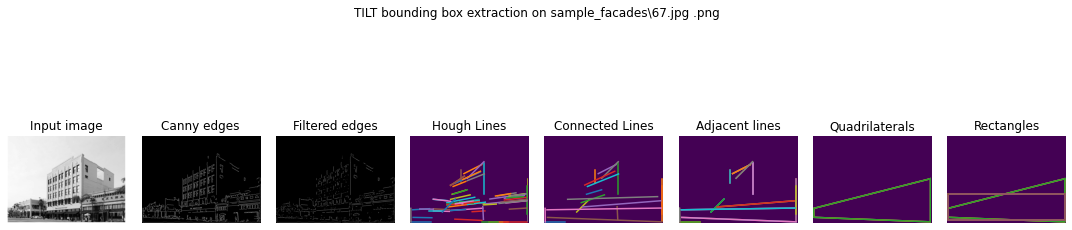

95
Edge Detection Finished
Edges Filtered
Computed Hough
Connected Lines
Found Connected Lines
Quadrilaterals formed
Rectangles formed


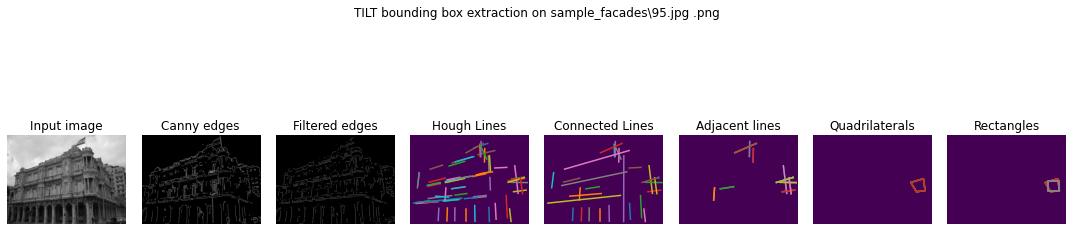

178
Edge Detection Finished
Edges Filtered
Computed Hough


In [ ]:
num_experiments, num_images = 20, 123
all_experiments = []
for extraction in ['Perimeter Averaging', 'Corner Thresholding', 'Area Thresholding']:
    if extraction == 'Corner Thresholding':
        experiments = run_experiments(num_experiments, num_images, threshold=4)
    else:
        experiments = run_experiments(num_experiments, num_images)
        all_experiments.append(experiments)